In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from itertools import product

warnings.filterwarnings("ignore")
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [179]:
country = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\GlobalLandTemperaturesByCountry.csv")
country["dt"] = pd.to_datetime(country["dt"])
country.set_index("dt", inplace=True)
country

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,4.384,2.294,Åland
1743-12-01,NaN,NaN,Åland
1744-01-01,NaN,NaN,Åland
1744-02-01,NaN,NaN,Åland
1744-03-01,NaN,NaN,Åland
...,...,...,...
2013-05-01,19.059,1.022,Zimbabwe
2013-06-01,17.613,0.473,Zimbabwe
2013-07-01,17.000,0.453,Zimbabwe


,AverageTemperature
dt,
1825-01-01,25.552167
1826-01-01,25.365000
1827-01-01,25.365000
1828-01-01,25.365000
1829-01-01,25.365000
...,...
2009-01-01,26.455000
2010-01-01,26.537000
2011-01-01,26.202250


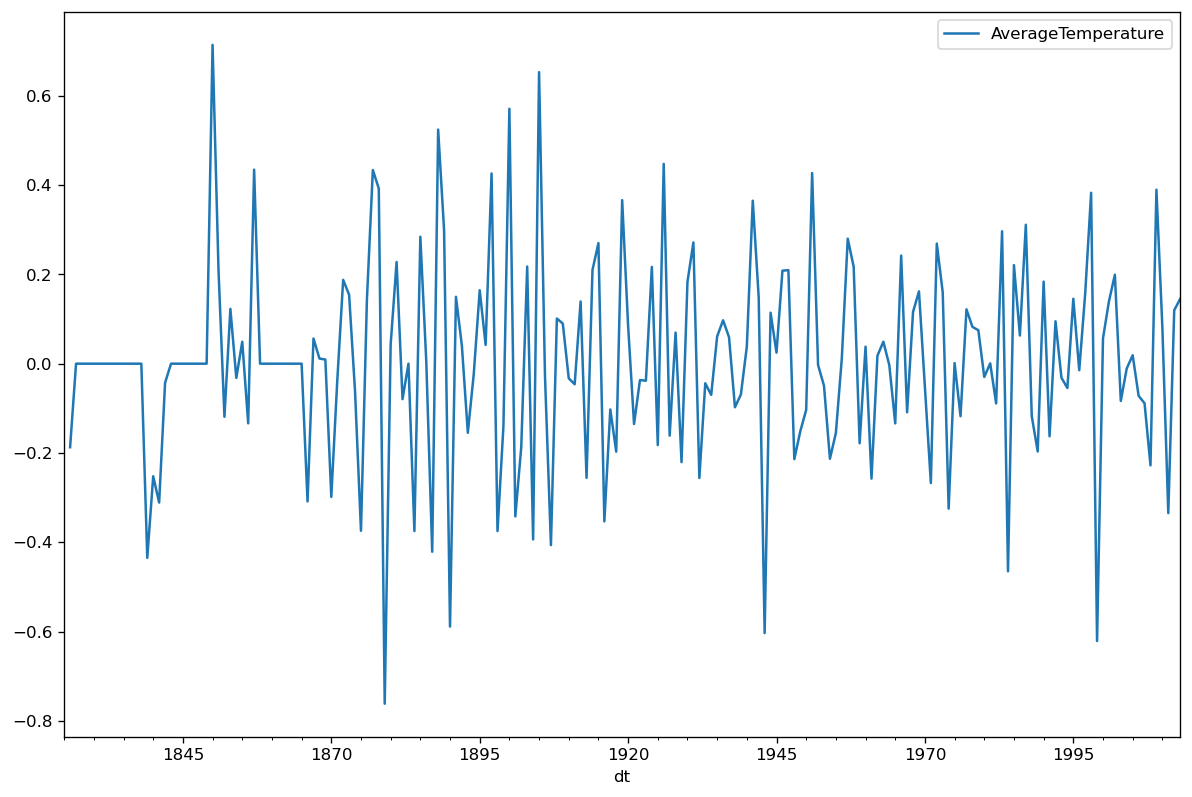

In [180]:
# filtering the dataframe to show only Indonesia
indo = country.copy()
indo = indo.loc[indo["Country"] == "Indonesia"]
indo.fillna(method='bfill', inplace=True)

# resampling the data to show the average temp of each decade
filtered = indo.resample("AS").mean()
filtered.drop("AverageTemperatureUncertainty", axis=1, inplace=True)

# first order of differentials
filtered.diff().plot(figsize=(12,8))
filtered

In [181]:
# checking the stationarity of the time series using Augmented Dicky-Fuller test
# finding the p value to proceed with differencing
# since p-value is larger than chosen threshold (5%), time series is not stationary
result = adfuller(filtered.AverageTemperature)
print("ADF Statistic: %f" %result[0])
print("p-value: %f" %result[1])

ADF Statistic: -1.155791
p-value: 0.692318


In [184]:
# checking the most optimal parameters for the ARIMA model using AIC
def optimize_ARIMA(order_list):
    """
        Return dataframe with parameters and corresponding AIC values
        order_list - list with (p, d, q) tuples
    """
    
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model_try = ARIMA(filtered.averageTemperature).fit(disp=1)
        except:
            continue
        aic = model_try.aic
        results.apped([order, aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ["(p, d ,q)", "AIC"]
    # Sort the dataframe in ascending order
    results_df = results_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    
    return results_df

In [189]:
# checking the best ARIMA model
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# make a list with all possible combination of p, d, q
parameters = product(ps, qs)
parameters_list = list(parameters)

# order_list = []
# for parameter in parameters_list:
#     parameter = list(parameter)
#     parameter.insert(1, 1)
#     parameter = tuple(parameter)
#     order_list.append(parameter)

#     results_df = optimize_ARIMA(order_list)


range(0, 8)


In [ ]:
# 111 ARIMA model
model = ARIMA(filtered.AverageTemperature, order=(7,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARIMA Model Results                               
Dep. Variable:     D.AverageTemperature   No. Observations:                  188
Model:                   ARIMA(7, 1, 3)   Log Likelihood                  36.999
Method:                         css-mle   S.D. of innovations              0.195
Date:                  Sat, 01 Jan 2022   AIC                            -49.998
Time:                          17:46:03   BIC                            -11.160
Sample:                      01-01-1826   HQIC                           -34.262
                           - 01-01-2013                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0049      0.008      0.601      0.548      -0.011       0.021
ar.L1.D.AverageTemperature     0.3333      0.075      4.452      0.

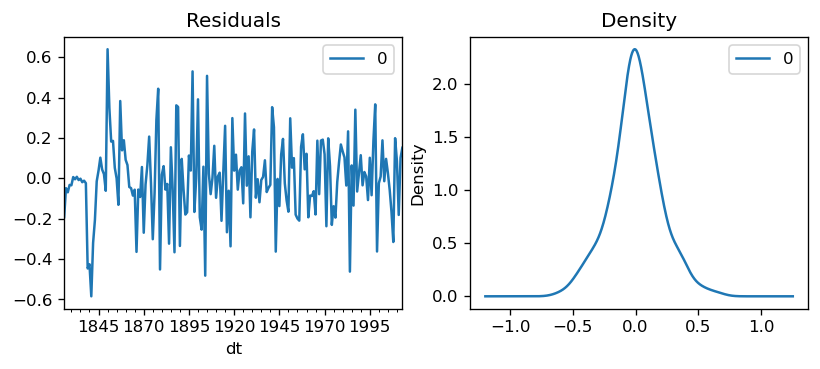

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
plt.rcParams.update({"figure.figsize": (8, 3), 'figure.dpi':120})
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title="Density", ax=ax[1])
plt.show()

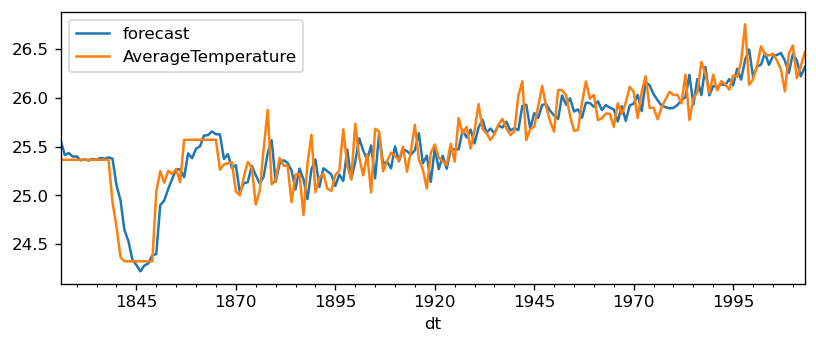

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()

[26.386568104752076, 26.363561220399813, 26.373650917432194, 26.418311154508896, 26.46883912355637, 26.489719866684844, 26.497746650709253, 26.496617136667844, 26.488800520672584, 26.475130582153298]


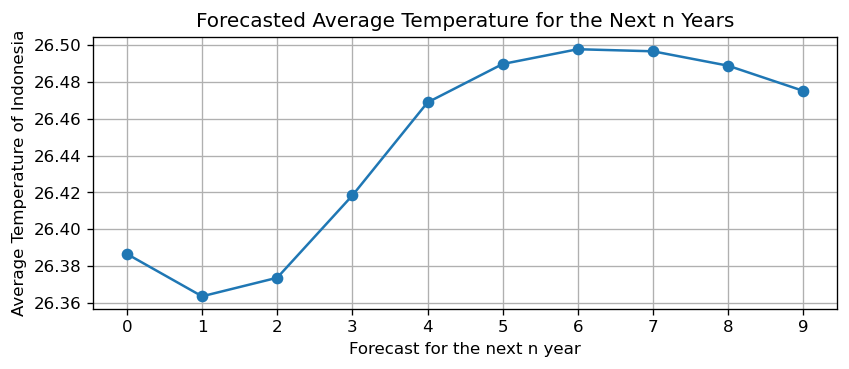

In [ ]:
forecast = model_fit.forecast(steps=10)[0]
forecast_values = []
for value in forecast:
    forecast_values.append(value)

plt.plot(range(0, len(forecast_values)), forecast_values, marker="o")
plt.xticks(range(0, len(forecast_values)))
plt.xlabel("Forecast for the next n year")
plt.ylabel("Average Temperature of Indonesia")
plt.title("Forecasted Average Temperature for the Next n Years")
plt.grid()
print(forecast_values)